In [1]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, arrowhead_marker
from highlight_text import  ax_text, fig_text
import ipywidgets as widgets
import matplotlib as mpl
import numpy as np

#Read in the data
df = pd.read_csv('Footballdata/New/ManUtdvsWolves.csv', encoding='latin-1')

#Temporary because teams are getting combined together
df['name'] = df['name'].str.cat(df['teamId'], sep='_')

#Adjust for pitch size
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#List it in a combo box
options = df["teamId"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
teamlist = widgets.Combobox(
    placeholder='Enter a name',
    options=options,
    description='Team:',
    ensure_option=True,
    disabled=False
)

teamlist

Combobox(value='', description='Team:', ensure_option=True, options=('Wolves', 'Manchester United'), placehold…

In [2]:
#Filter for player
team = teamlist.value
#df = df.loc[(df['teamId'] == team)]

#Remove Unsuccessful Aerials so that Successful Aerial Passes will be counted
df = df.loc[~((df['type_displayName'] == 'Aerial') & (df['outcomeType_displayName'] == 'Unsuccessful'))]

#Finding previous event
df['prevevent'] = df['type_displayName'].shift(1)

#Finding previous name
df['prevplayer'] = df['name'].shift(1)

#Finding 2nd previous event
df['prev2event'] = df['type_displayName'].shift(2)

#Finding 2nd previous outcome 
df['prev2outcome'] = df['outcomeType_displayName'].shift(2)

#Prev event has to be a recovery or a successful aerial by the same player
PRPassdf = df.loc[(df['type_displayName']== 'Pass') & (df['prevplayer'] == df['name']) & ((df['prevevent']== 'BallRecovery') |
                 ((df['prevevent'] == 'Aerial') & (df['prev2event'] == 'Pass') & (df['prev2outcome'] == 'Unsuccessful')))
                 ]
#& (df['period_displayName'] == 'FirstHalf')
#PRPassdf = df.loc[(df['type_displayName']== 'Pass') & (df['prevplayer'] == df['name']) & (df['prevevent']== 'BallRecovery')]

df1 = PRPassdf.loc[(PRPassdf['outcomeType_displayName'] == 'Successful')]
#df2 = PRPassdf.loc[(PRPassdf['outcomeType_displayName'] == 'Unsuccessful')]
df3 = df1.loc[df1['x'] < df1['endX']]

In [3]:
pd.options.mode.chained_assignment = None

#New variables to find progressive passes
df1['beginning'] = np.sqrt(np.square(120-df1['x']) + np.square(40-df1['y']))
df1['end'] = np.sqrt(np.square(120-df1['endX']) + np.square(40-df1['endY']))
df1['distance'] = df1['beginning'] - df1['end']

# At least 30m closer to the opponent’s goal if the starting and finishing points are within a team’s own half
# At least 15m closer to the opponent’s goal if the starting and finishing points are in different halves
# At least 10m closer to the opponent’s goal if the starting and finishing points are in the opponent’s half
df1['prog'] = np.where(((df1['x']< 60) & (df1['endX']< 60) & (df1['distance']>=32.80)) |
                      ((df1['x']< 60) & (df1['endX']>=60) & (df1['distance']>=16.40))  |
                      ((df1['x']>=60) & (df1['endX']>=60) & (df1['distance']>=10.94)),1,0)

#Variable for Passes that goes into Penalty Area 
df1['pen'] = np.where(((df1['endY'].between(16.88,63.12)) & (df1['endX']> 99.6)) &
                    (~((df1['y'].between(16.88,63.12)) & (df1['x']> 99.6))), 1, 0)

#Filter for progressive passes OR passes into penalty area
df1prog = df1.loc[(df1['prog']== 1) | (df1['pen']== 1)]

#Filter for progressive passes further from starting point
#df1prog = df1prog.loc[~((df1prog['x'] > df1prog['endX']) & (df1prog['prog']==1) & (df1prog['pen']==0))]

In [4]:
pass_list = PRPassdf.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Attempted Post-Recovery Passes'}).sort_values('name', ascending = True).reset_index()
del pass_list['index']

successful_pass_list = df1.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Successful Post-Recovery Passes'}).sort_values('name', ascending = True).reset_index()
del successful_pass_list['index']

prog_pass_list = df1prog.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Progressive Post-Recovery Passes'}).sort_values('name', ascending = True).reset_index()
del prog_pass_list['index']

forward_pass_list = df3.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Forward Post-Recovery Passes'}).sort_values('name', ascending = True).reset_index()
del forward_pass_list['index']

#Merge the list
PassList = pd.merge(pd.merge(pd.merge(pass_list, successful_pass_list, how='outer'), prog_pass_list, how='outer'), forward_pass_list, how='outer')
PassList.fillna(0, inplace=True)
PassList.rename(columns = {'name':'Player', 'teamId':'Team'},inplace = True)
PassList['Progressive Post-Recovery Passes'] = PassList['Progressive Post-Recovery Passes'].astype(int)
PassList['Successful Post-Recovery Passes'] = PassList['Successful Post-Recovery Passes'].astype(int)
PassList['Forward Post-Recovery Passes'] = PassList['Forward Post-Recovery Passes'].astype(int)

#Completion
PassList['Retention Rate %'] =((PassList['Successful Post-Recovery Passes'] / PassList['Attempted Post-Recovery Passes'])*100).round(decimals = 2)
PassList['Progression Rate %'] =((PassList['Progressive Post-Recovery Passes'] / PassList['Attempted Post-Recovery Passes'])*100).round(decimals = 2)
PassList['Forward Rate %'] = ((PassList['Forward Post-Recovery Passes'] / PassList['Successful Post-Recovery Passes'])*100).round(decimals = 2)

PassList = PassList.sort_values('Successful Post-Recovery Passes', ascending= False).reset_index(drop = True)
PassList.index += 1

PassList['Player'] = PassList['Player'].str.split('_').str[0]

PassList = PassList[['Player', 'Team', 'Successful Post-Recovery Passes']]
PassList.to_csv(r'C:\Users\user\Downloads\Passes\laliga2.csv', encoding='latin-1')

#print('\n'+team+"'s Post-Recovery Passes (Only Top 15 Players)")
PassList.head(40)

,Player,Team,Successful Post-Recovery Passes
1,Antony,Manchester United,8
2,Casemiro,Manchester United,7
3,Bruno Fernandes,Manchester United,6
4,Craig Dawson,Wolves,6
5,Rayan Aït-Nouri,Wolves,6
6,Nélson Semedo,Wolves,5
7,Mario Lemina,Wolves,5
8,Matheus Nunes,Wolves,4
9,Mason Mount,Manchester United,4
10,Pedro Neto,Wolves,4


In [5]:
#Combo box, choose players
options = df["name"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
playerlist = widgets.Combobox(
    placeholder='Enter a name',
    options=options,
    description='Player:',
    ensure_option=True,
    disabled=False
)
playerlist

Combobox(value='', description='Player:', ensure_option=True, options=('Bruno Fernandes_Manchester United', 'C…

In [6]:
player = playerlist.value

#All Passes from player
PRPassdf = PRPassdf.loc[(PRPassdf['name']==player)]
Attempts = len(PRPassdf.index)

#All Successful Passes from player
df1 = df1.loc[(df1['name']==player)]
successful = len(df1.index)

#All Prog Pass from player
df1prog = df1prog.loc[(df1prog['name']==player)]
progressive = len(df1prog.index)

#All Forward Pass from player
df3 = df3.loc[(df3['name']==player)]
forward = len(df3.index)

completion = round((successful / Attempts)*100,2)
progression = round((progressive / Attempts)*100,2)
forwarding = round((forward / successful)*100,2)

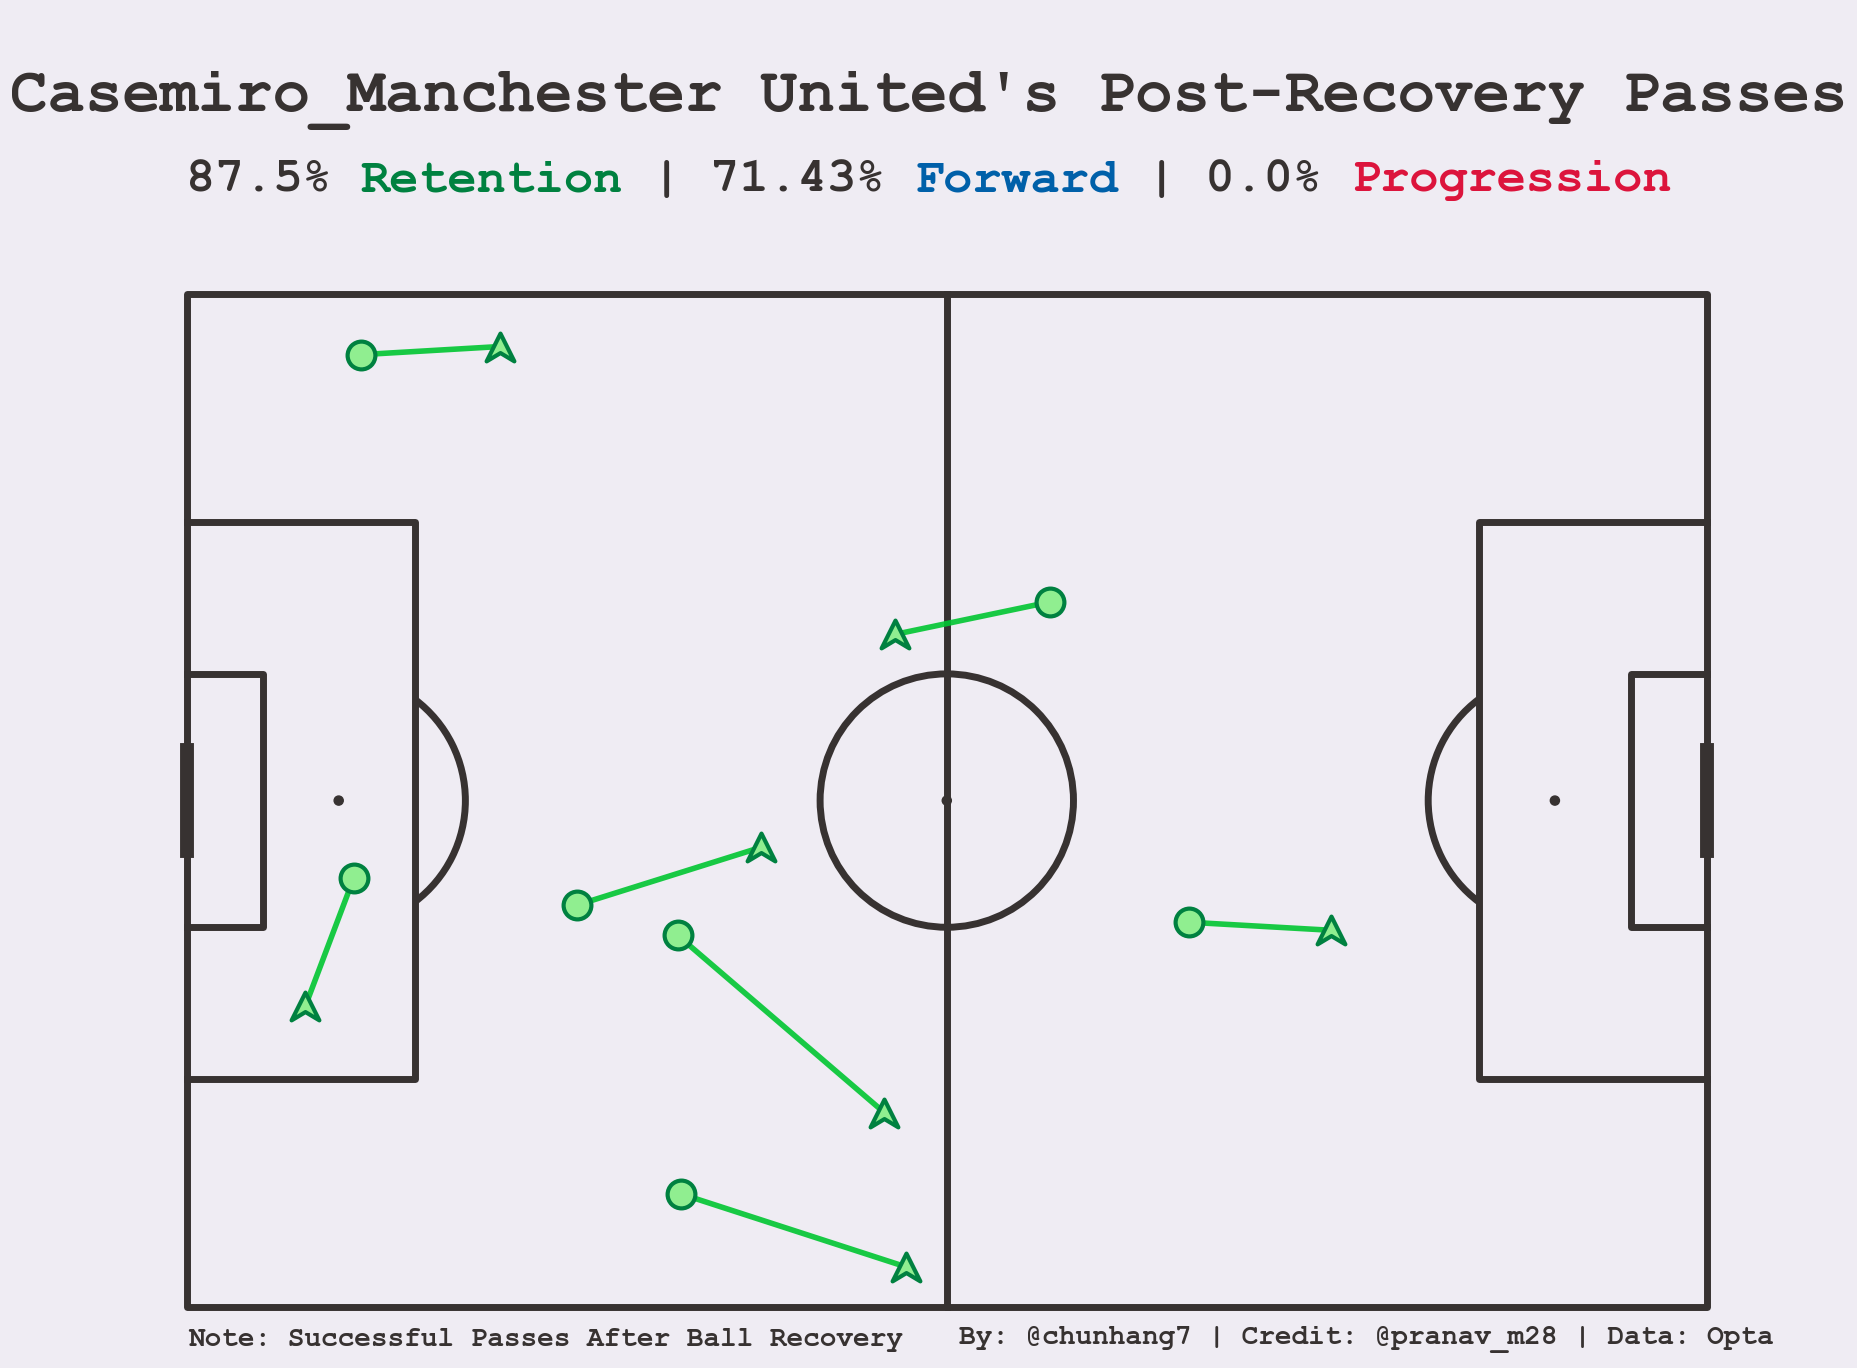

In [7]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#efecf3', line_color='#373231',linewidth=5, spot_scale=0.003)
fig, ax = pitch.draw(figsize=(18, 15), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#efecf3')

#Inverse y-axis
plt.gca().invert_yaxis()

#Successful Passes
pitch.scatter(df1.x,df1.y, edgecolors= '#008140', c='lightgreen',
              s = 400, zorder=4, ax=ax, marker = 'o', linewidth=3)

pitch.lines(df1.x,df1.y,df1.endX,df1.endY,
            ax=ax, color= '#00c631', lw=4, alpha = 0.9)

pitch.scatter(df1.endX,df1.endY, edgecolors= '#008140', c='lightgreen', marker=arrowhead_marker,
              s = 400, zorder=4, ax=ax, linewidth=3)

#Progressive Passes
pitch.scatter(df1prog.x, df1prog.y, edgecolors= 'crimson', c='orange',
              s = 400, zorder=4, ax=ax, marker = 'o', linewidth=3)

pitch.lines(df1prog.x, df1prog.y, df1prog.endX, df1prog.endY,
            ax=ax, color= 'red', lw=4, alpha = 0.9)

pitch.scatter(df1prog.endX, df1prog.endY, edgecolors= 'crimson', c='orange', marker=arrowhead_marker,
              s = 400, zorder=4, ax=ax, linewidth=3)

#Title & Annotations
fig.suptitle("\n"+player +"'s Post-Recovery Passes\n", fontsize=45, color='#373231',
            fontfamily = "Courier New", fontweight = "bold",y=0.96)

highlight_textprops =\
    [{"color": "#008140","fontweight": 'bold'},
     {"color": "#0060a9","fontweight": 'bold'},
     {"color": "crimson","fontweight": 'bold'}
    ]

Title = fig_text(s = str(completion) + "% <Retention> | " + str(forwarding) + "% <Forward> | " + str(progression) + "% <Progression>" ,
        x = 0.5, y = 0.86, highlight_textprops = highlight_textprops ,color='#373231',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=35);

#Credits
ax.text(0.1, -2.5, 'Note: Successful Passes After Ball Recovery', va='center', ha='left', fontsize=20, color='#373231',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(61, -2.5, "By: @chunhang7 | Credit: @pranav_m28 | Data: Opta", va='center', ha='left', fontsize=20, color='#373231',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()